In [270]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split

#from FFN_class_importable import FFN
#from Gillespie_method import gillespie

In [145]:
# Gillespie function
def gillespie(initial_states, transcription_rate, basal_transcript_rate, mRNA_degradation_rate, translation_rate, protein_degradation_rate, n, max_time):
    t = 0
    state = np.array(initial_states)
    times = [t]
    states = [state.copy()]

    while t < max_time:
        TetR_mRNA, TetR_protein, cI_mRNA, cI_protein, LacI_mRNA, LacI_protein = state

        # Propensities
        a = np.array([
            (transcription_rate / (1 + LacI_protein ** n)) + basal_transcript_rate,  # production of TetR_mRNA
            mRNA_degradation_rate * TetR_mRNA,  # degradation of TetR_mRNA
            translation_rate * TetR_mRNA,  # production of TetR protein
            protein_degradation_rate * TetR_protein,  # degradation of TetR protein

            (transcription_rate / (1 + TetR_protein ** n)) + basal_transcript_rate,  # production of cI_mRNA
            mRNA_degradation_rate * cI_mRNA,  # degradation of cI_mRNA
            translation_rate * cI_mRNA,  # production of cI protein
            protein_degradation_rate * cI_protein,  # degradation of cI protein

            (transcription_rate / (1 + cI_protein ** n)) + basal_transcript_rate,  # production of LacI_mRNA
            mRNA_degradation_rate * LacI_mRNA,  # degradation of LacI_mRNA
            translation_rate * LacI_mRNA,  # production of LacI protein
            protein_degradation_rate * LacI_protein  # degradation of LacI protein
        ])

        a0 = np.sum(a)
        if a0 == 0:
            break

        r1 = np.random.random()
        tau = (1 / a0) * np.log(1 / r1)

        r2 = np.random.uniform(0, 1)
        cumulative_sum = np.cumsum(a)
        reaction_index = np.searchsorted(cumulative_sum, r2 * a0)

        # Update the system
        state_changes = [
            [1, 0, 0, 0, 0, 0],   # mRNA_TetR production
            [-1, 0, 0, 0, 0, 0],  # mRNA_TetR degradation
            [0, 1, 0, 0, 0, 0],   # protein_TetR production
            [0, -1, 0, 0, 0, 0],  # protein_TetR degradation

            [0, 0, 1, 0, 0, 0],   # mRNA_cI production
            [0, 0, -1, 0, 0, 0],  # mRNA_cI degradation
            [0, 0, 0, 1, 0, 0],   # protein_cI production
            [0, 0, 0, -1, 0, 0],  # protein_cI degradation

            [0, 0, 0, 0, 1, 0],   # mRNA_LacI production
            [0, 0, 0, 0, -1, 0],  # mRNA_LacI degradation
            [0, 0, 0, 0, 0, 1],   # protein_LacI production
            [0, 0, 0, 0, 0, -1],  # protein_LacI degradation
        ]

        state += state_changes[reaction_index]
        t += tau

        times.append(t)
        states.append(state.copy())

    return np.array(times), np.array(states)
    

In [311]:

# Chopped and changed class
class FFN_change:
    def __init__(self, input_data, output_data, hidden_layers, activation_functions, epochs, learning_rate, batch_size):
        self.input_data = input_data  # Make sure this is a numpy array
        self.output_data = output_data
        self.hidden_layers = hidden_layers
        self.activation_functions = activation_functions
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.weights_dictionary = {}
        self.activations_dictionary = {}
        self.initialize()
##### an improvement could be if you have a method that allows you to input new data to further train your data
    def initialize(self):
        last_layer = self.input_data.shape[0]
        for i in range(len(self.hidden_layers)):
            self.weights_dictionary[f'w{i}'] = 0.1 * np.random.randn(self.hidden_layers[i], last_layer)
            self.weights_dictionary[f'b{i}'] = np.zeros((self.hidden_layers[i], 1))
            last_layer = self.hidden_layers[i]
        self.weights_dictionary['last_weight'] = 0.1 * np.random.randn(self.output_data.shape[0], last_layer)
        self.weights_dictionary['last_bias'] = np.zeros((self.output_data.shape[0], 1))
        
    def forward(self, input_batch): 
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.weights_dictionary[f'w{i}'], input_batch) + self.weights_dictionary[f'b{i}']
            a = self.activation(z, self.activation_functions[i])
            self.activations_dictionary[f'z{i + 1}'] = z
            self.activations_dictionary[f'a{i + 1}'] = a
            input_batch = a  
        a = np.dot(self.weights_dictionary['last_weight'], input_batch) + self.weights_dictionary["last_bias"]
        self.activations_dictionary['activation_output'] = a

    def activation(self, a, activation_function):
        if activation_function[0] == "relu":
            return np.maximum(0, a)
        elif activation_function[0] == "sigmoid":
            return 1 / (1 + np.exp(-a))
        elif activation_function[0] == "tanh":
            return np.tanh(a)
        elif activation_function[0] == "lrelu":
            return np.maximum(activation_function[1] * a, a) 
        else:
            raise Exception("Invalid activation function")

    def activation_derivative(self, a, activation_function):
        if activation_function[0] == 'relu':
            return np.where(a > 0, 1, 0)
        elif activation_function[0] == 'sigmoid':
            sig = self.activation(a, ('sigmoid', 0))
            return sig * (1 - sig)
        elif activation_function[0] == 'tanh':
            return 1 - np.tanh(a) ** 2
        elif activation_function[0] == 'lrelu':
            dx = np.ones_like(a)
            dx[a <= 0] = activation_function[1]
            return dx
        else:
            raise Exception("Invalid activation function derivative")

    def backward(self, dvalues, input_batch):
        i = len(self.hidden_layers)
        self.weights_dictionary["dweights last_weight"] = np.dot(dvalues, self.activations_dictionary[f'a{i}'].T)
        self.weights_dictionary["dbiases last_bias"] = np.sum(dvalues, axis=1, keepdims=True)
        dinputs = np.dot(self.weights_dictionary["last_weight"].T, dvalues)
        
        for i in range(len(self.hidden_layers) - 1, -1, -1):
            dinputs *= self.activation_derivative(self.activations_dictionary[f'z{i + 1}'], self.activation_functions[i])
            self.weights_dictionary[f'dweights{i}'] = np.dot(dinputs, self.activations_dictionary[f'a{i}'].T if i > 0 else input_batch.T)
            self.weights_dictionary[f'dbiases{i}'] = np.sum(dinputs, axis=1, keepdims=True)
            if i > 0:
                dinputs = np.dot(self.weights_dictionary[f'w{i}'].T, dinputs)

    def compute_loss(self, predictions, targets):
        return np.mean((predictions - targets) ** 2) 

    def loss_backwards(self, predictions, targets):
        return 2 * (predictions - targets) / targets.shape[1] 

    def train(self):
        epoch_data = []
        loss_history = []
        for epoch in range(self.epochs):
            epoch_loss = 0
            batch_count = 0
            
            for start in range(0, self.input_data.shape[1], self.batch_size):
                end = min(start + self.batch_size, self.input_data.shape[1])
                input_batch = self.input_data[:, start:end]
                output_batch = self.output_data[:, start:end]
                
                self.forward(input_batch)
                loss = self.compute_loss(self.activations_dictionary["activation_output"], output_batch)
                dvalues = self.loss_backwards(self.activations_dictionary["activation_output"], output_batch)
                self.backward(dvalues, input_batch)
                self.update()
                
                epoch_loss += loss
                batch_count += 1
            
            epoch_loss /= batch_count
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss}")
                epoch_data.append(epoch)
                loss_history.append(epoch_loss)

        plt.plot(epoch_data, loss_history)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title("Epoch Number vs Loss")
        plt.show()
        
    def update(self):
        for i in range(len(self.hidden_layers)):
            self.weights_dictionary[f'w{i}'] -= self.learning_rate * self.weights_dictionary[f'dweights{i}']
            self.weights_dictionary[f'b{i}'] -= self.learning_rate * self.weights_dictionary[f'dbiases{i}']
        self.weights_dictionary["last_weight"] -= self.learning_rate * self.weights_dictionary["dweights last_weight"]
        self.weights_dictionary["last_bias"] -= self.learning_rate * self.weights_dictionary["dbiases last_bias"]


    def predict(self, input_data, output_data):
        self.forward(input_data)
        loss = self.compute_loss(self.activations_dictionary["activation_output"], output_data)
        return loss, self.activations_dictionary["activation_output"]

    

In [147]:
## original class!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# create the class FFN:
# a time stepper that takes in (input_data, output_data, hidden_layers (list), activation_function (list of tuples), epochs, learning rate, batch_size)
# going to assume mean squared error and stochastic gradient descent.
class FFN:
    def __init__(self, input_data, output_data, hidden_layers, activation_functions, epochs, learning_rate, batch_size):
        self.input_data = input_data ## make sure this is a numpy array
        self.output_data = output_data
        self.hidden_layers = hidden_layers
        self.activation_functions = activation_functions
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.weights_dictionary = {}
        self.activations_dictionary = {}
        self.initialize()


    def initialize(self):
        last_layer = self.input_data.shape[0]
        for i in range(len(self.hidden_layers)):
            #print(i)
            self.weights_dictionary[f'w{i}'] = 0.1 * np.random.randn(self.hidden_layers[i], last_layer)
            self.weights_dictionary[f'b{i}'] = np.zeros((self.hidden_layers[i], 1))
            last_layer = self.hidden_layers[i]
        self.weights_dictionary['last_weight'] = 0.1 * np.random.randn(self.output_data.shape[0], last_layer)
        self.weights_dictionary['last_bias'] = np.zeros((self.output_data.shape[0], 1))
        
                
    def forward(self, input_batch): #setting up to be called within the training method for each batch
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.weights_dictionary[f'w{i}'], input_batch) + self.weights_dictionary[f'b{i}'] # so weights of first layer are 
            #print(f' input {input_batch.shape}', f"biases {self.weights_dictionary[f'b{i}'].shape}", f"weights {self.weights_dictionary[f'w{i}'].shape}")
            a = self.activation(z, self.activation_functions[i]) # should have shape (neurons in layer 1, batch size)
            self.activations_dictionary[f'z{i + 1}'] = z #activation (prefunction) of the first hidden layer is added as z1 
            self.activations_dictionary[f'a{i + 1}'] = a #activation of first layer added as a1
            input_batch = a
        #print(f'weights {self.weights_dictionary["last_weight"].shape}', f'input {input_batch.shape}', f'biases {self.weights_dictionary["last_bias"].shape}')   
        a = np.dot(self.weights_dictionary['last_weight'], input_batch) + self.weights_dictionary["last_bias"]
        self.activations_dictionary['activation_output'] = a
        
        ## so much cleaner instead of having to index a load of lists and potentially reverse them etc.
        
    def activation(self, a, activation_function):
        if activation_function[0] == "relu":
            return np.maximum(0, a)
        elif activation_function[0] == "sigmoid":
            return 1 / (1 + np.exp(-a))
        elif activation_function[0] == "tanh":
            return np.tanh(a)
        elif activation_function[0] == "lrelu": # THink about how you can have an alpha parameter when you want it 
            return np.maximum(activation_function[1] * a, a) 
        else:
            raise Exception("Invalid activation function")

    def activation_derivative(self, a, activation_function): # check this you should remember what function you had
        
        if activation_function[0] == 'relu':
            return np.where(a > 0, 1, 0)
        elif activation_function[0] == 'sigmoid':
            sig = self.activation(a, ('sigmoid', 0))
            return sig * (1 - sig)
        elif activation_function[0] == 'tanh':
            return 1 - np.tanh(a)**2
        elif activation_function[0] == 'lrelu':
            dx = np.ones_like(input)
            dx[a <= 0] = activation_function[1]   # THink about how you can have an alpha parameter when you want it 
            return dx
        
        else:
            raise Exception("Invalid activation function derivative")

    def backward(self, dvalues, input_batch): ## just need the dictionary key for the output activations and the output batch
        ## computing the loss gradient here
        i = len(self.hidden_layers)
        #print( f'loss gradients shape {dvalues.shape}', f"output {self.activations_dictionary[f'a{i}'].T.shape}")
        self.weights_dictionary["dweights last_weight"] = np.dot(dvalues, self.activations_dictionary[f'a{i}'].T) #if this dont work switch them...
        self.weights_dictionary["dbiases last_bias"] = np.sum(dvalues, axis = 1, keepdims=True)
        dinputs = np.dot(self.weights_dictionary["dweights last_weight"].T, dvalues)
  
        for i in range(len(self.hidden_layers)-1, -1, -1):
            dinputs *= self.activation_derivative(self.activations_dictionary[f'z{i+1}'], self.activation_functions[i])
            self.weights_dictionary[f'dweights{i}'] = np.dot(dinputs, self.activations_dictionary[f'a{i}'].T if i > 0 else input_batch.T)  # Added condition for input_batch
            self.weights_dictionary[f'dbiases{i}'] = np.sum(dinputs, axis=1, keepdims=True)
            if i > 0:
                dinputs = np.dot(self.weights_dictionary[f'w{i}'].T, dinputs)
            #print(f"dweights shape{self.weights_dictionary[f'dweights{i}'].shape}", f"dbias shape{self.weights_dictionary[f'dbiases{i}'].shape}", f"dinputs shape{dinputs.shape}")

        
        
    def compute_loss(self, predictions, targets):
        return np.mean((predictions - targets) ** 2) # the loss function averaged out for normalisation
        



    def loss_backwards(self, predictions, targets):
        return 2 * (predictions - targets) / len(targets) # the loss function averaged out for normalisation






    def train(self):
        epoch_data = []
        loss_history = []
        for epoch in range(self.epochs):
            for start in range(0, self.input_data.shape[1], self.batch_size):
                start = start
                end = start + self.batch_size
                #print(f'end {end}')
                input_batch = self.input_data[:,start:end]
                #print(f'batchinputs {input_batch.shape}')
                output_batch = self.output_data[:,start:end]
                #print(f'batchoutputs {output_batch.shape}')
            
                 # should be minibatches but for now no
                 # same here
                self.forward(input_batch)
                loss = self.compute_loss(self.activations_dictionary["activation_output"], output_batch) # should be a function calling usual MSE
                dvalues = self.loss_backwards(self.activations_dictionary["activation_output"], output_batch)
                self.backward(dvalues, input_batch)
                self.update()
    
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
                epoch_data.append(epoch)
                loss_history.append(loss)

        plt.plot(epoch_data, loss_history)
        plt.xlabel("Iteration Number")
        plt.ylabel("Loss")
        plt.title("Iteration Number vs Loss")
        plt.show()
        
    def update(self):
        for i in range(0, len(self.hidden_layers)):
            self.weights_dictionary[f'w{i}'] -= self.learning_rate * self.weights_dictionary[f'dweights{i}']
            self.weights_dictionary[f'b{i}'] -= self.learning_rate * self.weights_dictionary[f'dbiases{i}']
        self.weights_dictionary["last_weight"] -= self.learning_rate * self.weights_dictionary["dweights last_weight"]
        self.weights_dictionary["last_bias"] -= self.learning_rate * self.weights_dictionary["dbiases last_bias"]
        

    def predict(self, input_data):
        self.forward(input_data)
        return self.activations_dictionary['activation_output']
        

In [170]:
### start by developing your data set, this is the trial for one run
initial_states = [0, 3, 0, 0, 0, 0]
# initial states structure is mRNA_TetR, protein_TetR, mRNA_cI, protein_cI, mRNA_LacI, protein_LacI

# Parameters (example values, adjust as necessary)
transcription_rate = 50
basal_transcript_rate = 0.01
mRNA_degradation_rate = 1
translation_rate = 5
protein_degradation_rate = 2
n = 2  # Hill coefficient
max_time = 100

# Run the simulation
times, states = gillespie(initial_states, transcription_rate, basal_transcript_rate, mRNA_degradation_rate, translation_rate, protein_degradation_rate, n, max_time)

In [149]:
print(states.shape)
print(times.shape)

(8115, 6)
(8115,)


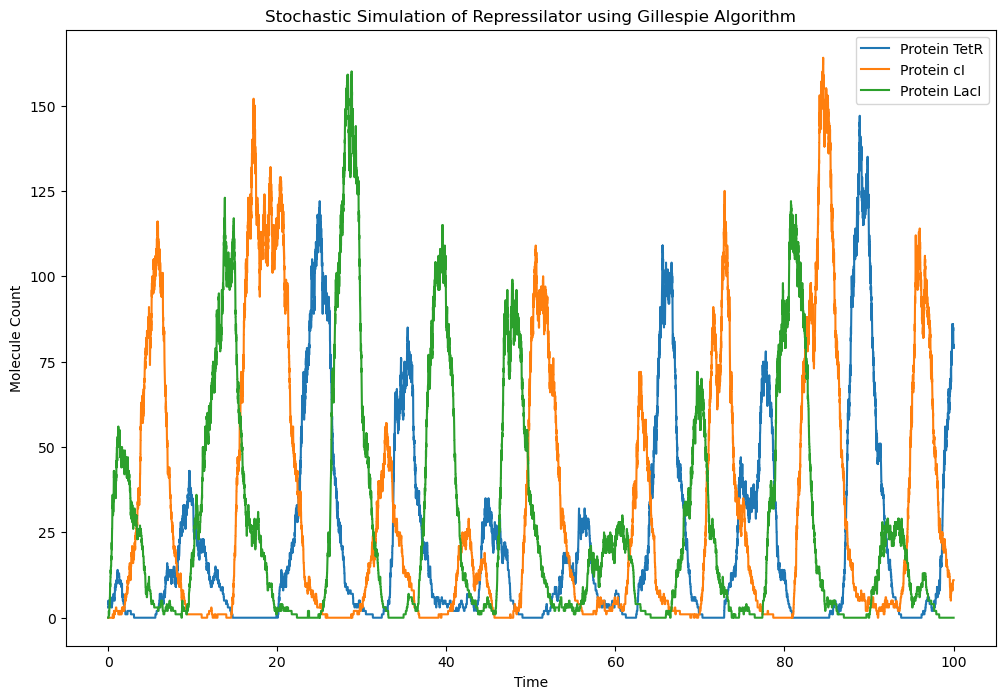

In [172]:
mRNA_TetR = states[:, 0]
protein_TetR = states[:, 1]
mRNA_cI = states[:, 2]
protein_cI = states[:, 3]
mRNA_LacI = states[:, 4]
protein_LacI = states[:, 5]

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(times, protein_TetR, label='Protein TetR')
plt.plot(times, protein_cI, label='Protein cI')
plt.plot(times, protein_LacI, label='Protein LacI')
plt.xlabel('Time')
plt.ylabel('Molecule Count')
plt.legend()
plt.title('Stochastic Simulation of Repressilator using Gillespie Algorithm')
plt.show()

In [ ]:
#### how can I make a data set 
#### see Gillespie neural network notebook for dataset method
#original dataset maker
def dataset_maker(dataset_size):
    X_train = []
    Y_train = []
    times, states = gillespie(initial_states, transcription_rate, basal_transcript_rate, mRNA_degradation_rate, translation_rate, protein_degradation_rate, n, max_time)# run gillespie
    #matrix_repeat = np.tile(times, (6, 1))
    #print(matrix_repeat)
    states = states.T
    #print(f'times shape{matrix_repeat.shape} states shape {states.shape}')
    X_train = states[:,0:1000]
    Y_train = states[:,1:1001]
    print(f'Y_train shape{X_train.shape} Y_train shape {Y_train.shape}')
    
    for size in range(dataset_size - 1):
        times, states = gillespie(initial_states, transcription_rate, basal_transcript_rate, mRNA_degradation_rate, translation_rate, protein_degradation_rate, n, max_time)# run gillespie
        #matrix_repeat = np.tile(times, (6, 1))
        #print(matrix_repeat)
        states = states.T
        print(f'states shape {states.shape}')
        X_train = np.hstack((X_train, states[:,0:1000]))
        Y_train = np.hstack((Y_train, states[:,1:1001]))
        print(f'Y_train shape{X_train.shape} Y_train shape {Y_train.shape}')
        
    return X_train, Y_train

X_train, Y_train = dataset_maker(5)
print(f'X_train {X_train.shape} Y_train {Y_train.shape}')
# this hasnt really worked, the dataset needs to be shape(6, num datapoints)

In [242]:
## new dataset where I bin the data from one long run of Gillespie
## delta is the change in indicies between input and output data
def dataset(run_length, delta = 1, normalisations = False):
    X_train = []
    Y_train = []
    times, states = gillespie(initial_states, transcription_rate, basal_transcript_rate, mRNA_degradation_rate, translation_rate, protein_degradation_rate, n, run_length)# run gillespie
    states = states.T
    s = states.shape[1]
    print(f'states shape {states.shape}')
    X_train = states[:,0: s-delta]
    Y_train = states[:,delta: s]
    print(f'X_train shape{X_train.shape} Y_train shape {Y_train.shape}')
    ## Normalise --> see notebook for explanation
    x_mean = np.mean(X_train, axis = 1, keepdims = True)
    x_std = np.std(X_train, axis = 1, keepdims = True)
    X_train = (X_train - x_mean) / x_std
    y_mean = np.mean(Y_train, axis = 1, keepdims = True)
    y_std = np.std(Y_train, axis = 1, keepdims = True)
    print(y_std.shape)
    Y_train = (Y_train - y_mean) / y_std    
    print(f'X_train shape{X_train.shape} Y_train shape {Y_train.shape}')
    # if we want the normalisations or not
    if normalisations:
        return X_train, Y_train, times, y_mean, y_std
    else:    
        return X_train, Y_train, times
    
X_train, Y_train, times = dataset(20, 100)

states shape (6, 9904)
X_train shape(6, 9804) Y_train shape (6, 9804)
(6, 1)
X_train shape(6, 9804) Y_train shape (6, 9804)


Epoch 0, Loss: 0.2013965813729084
Epoch 100, Loss: 0.10064410971509612
Epoch 200, Loss: 0.01077976294292525
Epoch 300, Loss: 0.00956151994825226
Epoch 400, Loss: 0.009091272478999487


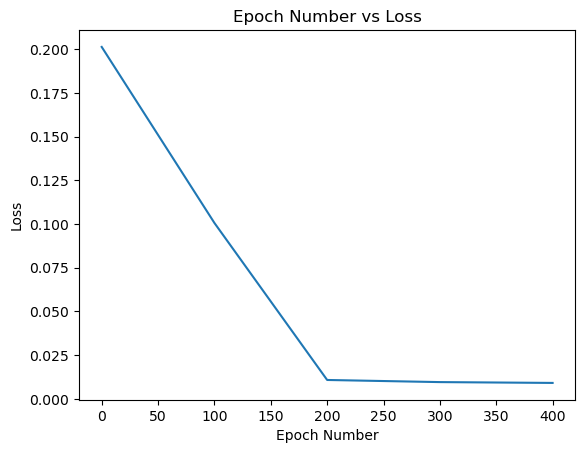

In [243]:
#(input_data, output_data, hidden_layers (list), activation_function (list of tuples), epochs, learning rate, batch_size)
Gillespie = FFN_change(X_train, Y_train,[64, 64, 64], [("sigmoid", 0.5), ("sigmoid", 0.5), ("sigmoid", 0.5)], 500, 0.1, 50)

Gillespie.train()
# 455.00144363675315

In [256]:
### going to make a predicter that uses the supposedly trained models predictions...
delta = 100
input_test, output_test, times, y_mean, y_std = dataset(10, delta, True)
print(times.shape)

states shape (6, 3269)
X_train shape(6, 3169) Y_train shape (6, 3169)
(6, 1)
X_train shape(6, 3169) Y_train shape (6, 3169)
(3269,)


(3169, 6)
(3169,)
[ 2.07936167  1.49338235  1.86110749 ... 41.22241691 41.05987277
 41.22241691]


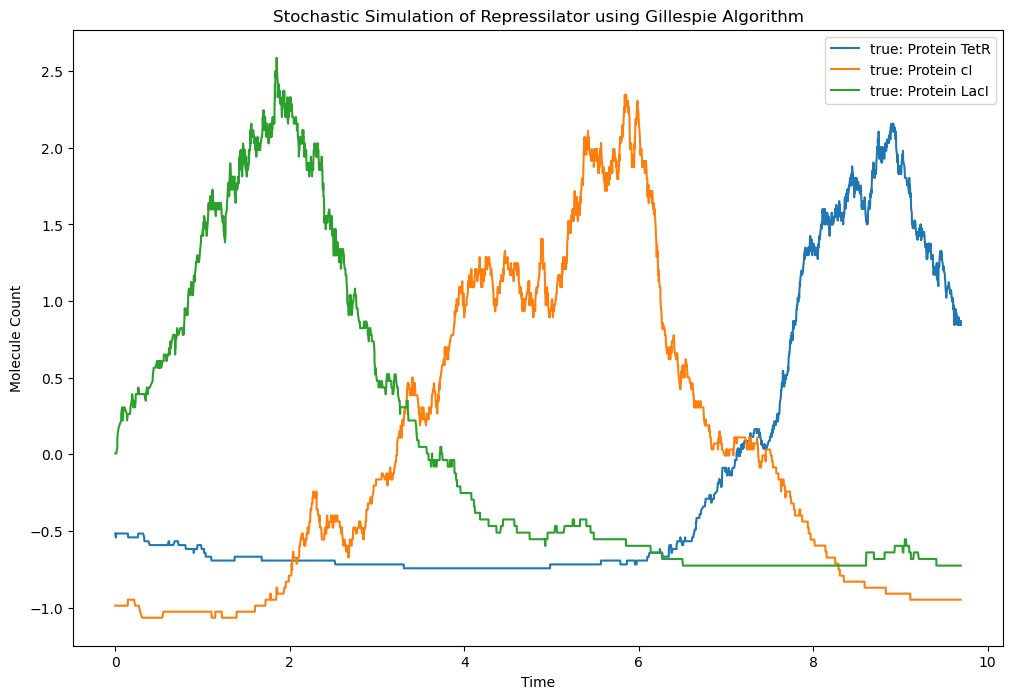

In [257]:
## transposing the prediction and then unnormalizing it effectively
prediction = Gillespie.predict(input_test).T
prediction = (prediction * y_std.T) + y_mean.T
times = times[:times.shape[0]-delta]
print(prediction.shape)
print(times.shape)
#predicted values
predicted_mRNA_TetR = prediction[:, 0]
print(predicted_mRNA_TetR)
predicted_protein_TetR = prediction[:, 1]
predicted_mRNA_cI = prediction[:, 2]
predicted_protein_cI = prediction[:, 3]
predicted_mRNA_LacI = prediction[:, 4]
predicted_protein_LacI = prediction[:, 5]

#true values
true_mRNA_TetR = output_test[0, :]
true_protein_TetR = output_test[1, :]
true_mRNA_cI = output_test[2, :]
true_protein_cI = output_test[3, :]
true_mRNA_LacI = output_test[4, :]
true_protein_LacI = output_test[5, :]

# Plot the results
plt.figure(figsize=(12, 8))
# plt.plot(times, predicted_protein_TetR, label='prediction: Protein TetR')
# plt.plot(times, predicted_protein_cI, label='prediction: Protein cI')
# plt.plot(times, predicted_protein_LacI, label='prediction: Protein LacI')
plt.plot(times, true_protein_TetR, label='true: Protein TetR')
plt.plot(times, true_protein_cI, label='true: Protein cI')
plt.plot(times, true_protein_LacI, label='true: Protein LacI')
plt.xlabel('Time')
plt.ylabel('Molecule Count')
plt.legend()
plt.title('Stochastic Simulation of Repressilator using Gillespie Algorithm')
plt.show()

In [269]:
### have curated a dataset in another file to product Gillespie_data.csv which I can now use to train
df = pd.read_csv("Gillespie_data2.csv")
norm_values = pd.read_csv("norm_values2.csv")
# now want to regroup X and Y train as matrices

# Extract the 'Times' column.
times = df['Times'].values

# Extract the relevant columns for X_train and Y_train
X_columns = ['X_mRNA_TetR', 'X_protein_TetR', 'X_mRNA_cI', 'X_protein_cI', 'X_mRNA_LacI', 'X_protein_LacI']
Y_columns = ['Y_mRNA_TetR', 'Y_protein_TetR', 'Y_mRNA_cI', 'Y_protein_cI', 'Y_mRNA_LacI', 'Y_protein_LacI']

X_train = df[X_columns].values.T  # Transpose to get shape (6, len(times))
Y_train = df[Y_columns].values.T  # Transpose to get shape (6, len(times))

y_mean = norm_values["y_mean"].values.reshape((6, 1))
y_std = norm_values["y_std"].values.reshape((6, 1))
x_mean = norm_values["x_mean"].values.reshape((6, 1))
x_std = norm_values["x_std"].values.reshape((6, 1))



print(f'y_mean {y_mean.shape} y_std {y_std.shape} x_mean {x_mean.shape} x_std {x_std.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')



y_mean (6, 1) y_std (6, 1) x_mean (6, 1) x_std (6, 1)
X_train shape: (6, 9980)
Y_train shape: (6, 9980)


In [ ]:
## train, validation, test splitting using scikitlearn. split or something
## train the data
## produce a prediction using the output of a pass being put back into the network to produce a completley predicted run...

In [271]:


# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train.T, Y_train.T, test_size=0.2, shuffle=False)

# Transpose back to get shapes (6, num_train_samples) and (6, num_test_samples)
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_test shape: {Y_test.shape}')


X_train shape: (6, 7984)
X_test shape: (6, 1996)
Y_train shape: (6, 7984)
Y_test shape: (6, 1996)


Epoch 0, Loss: 0.8924868820251615
Epoch 100, Loss: 0.03547808477159672
Epoch 200, Loss: 0.032288296821546714
Epoch 300, Loss: 0.0274808015098493
Epoch 400, Loss: 0.02410112196662767
Epoch 500, Loss: 0.022030186177188334
Epoch 600, Loss: 0.020878664257588782
Epoch 700, Loss: 0.02005332349817065
Epoch 800, Loss: 0.019384732180196516
Epoch 900, Loss: 0.018834898226072982


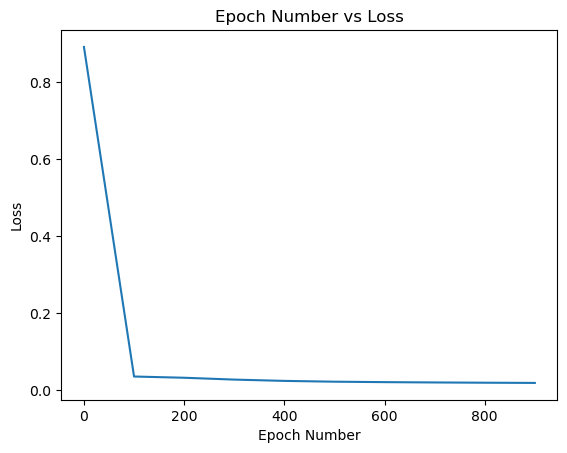

In [312]:
Gillespie_ml = FFN_change(X_train, Y_train,[64, 64, 64], [("sigmoid", 0.5), ("sigmoid", 0.5), ("sigmoid", 0.5)], 1000, 0.1, 50)
Gillespie_ml.train()

In [313]:
## now compare it to the test set... (I don't know how to do it)

loss, output =Gillespie_ml.predict(X_test, Y_test)
print(loss)

0.03487753406977742


2.1471621926870705


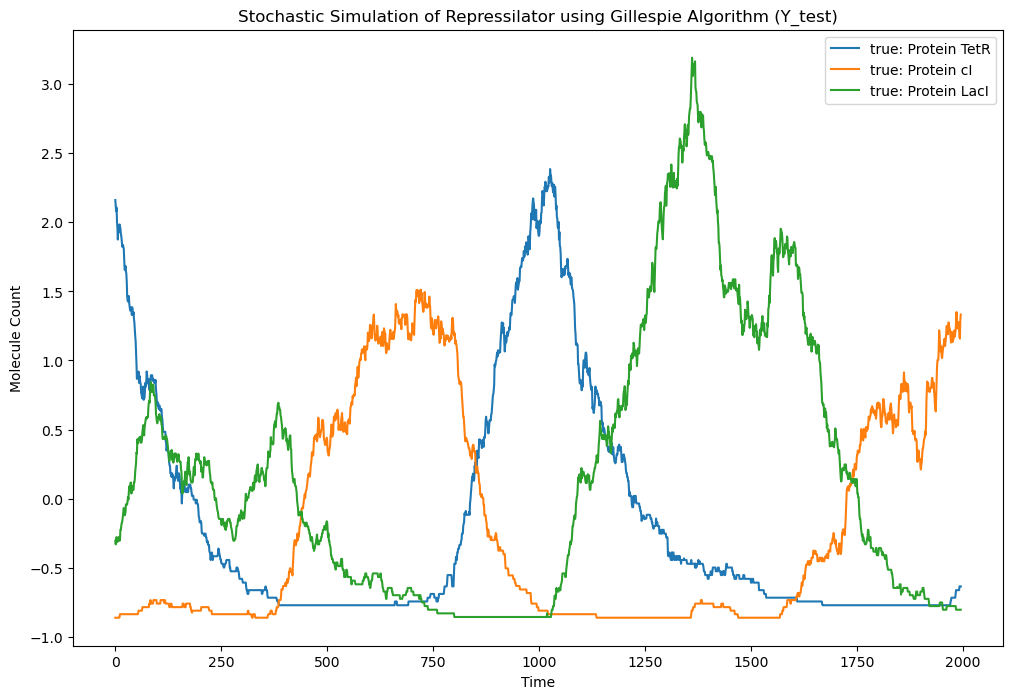

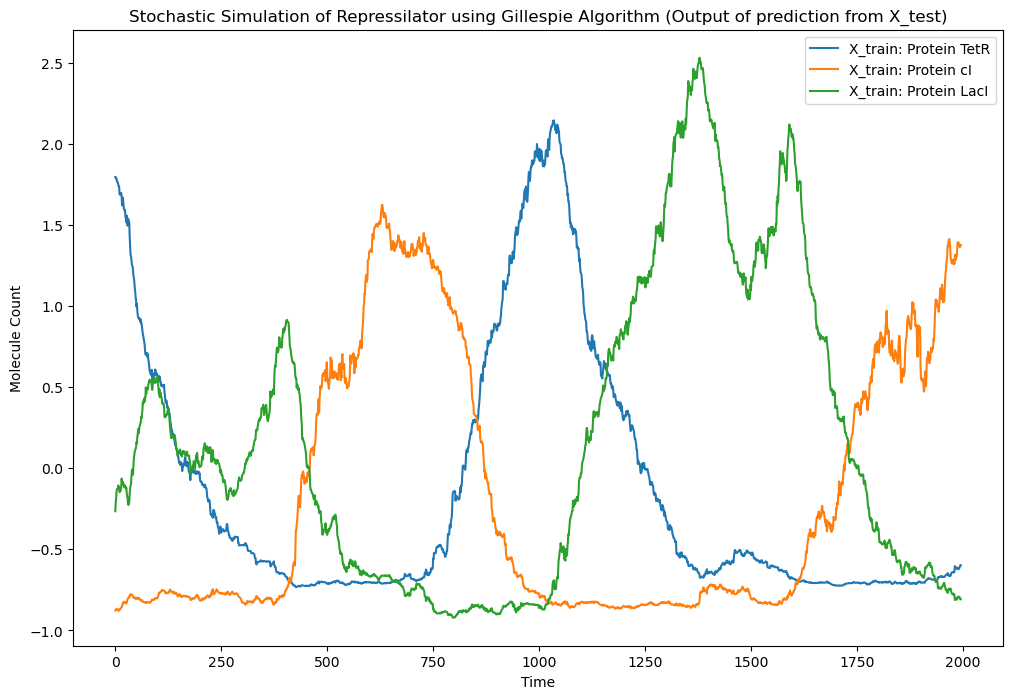

In [319]:
times = np.arange(0, output.shape[1])
predicted_mRNA_TetR = output[0, :]
predicted_protein_TetR = output[1, :]
print(max(predicted_protein_TetR))
predicted_mRNA_cI = output[2, :]
predicted_protein_cI = output[3, :]
predicted_mRNA_LacI = output[4, :]
predicted_protein_LacI = output[5, :]

#true values
true_mRNA_TetR = Y_test[0, :]
true_protein_TetR = Y_test[1, :]
true_mRNA_cI = Y_test[2, :]
true_protein_cI = Y_test[3, :]
true_mRNA_LacI = Y_test[4, :]
true_protein_LacI = Y_test[5, :]

plt.figure(figsize=(12, 8))

plt.plot(times, true_protein_TetR, label='true: Protein TetR')
plt.plot(times, true_protein_cI, label='true: Protein cI')
plt.plot(times, true_protein_LacI, label='true: Protein LacI')
plt.xlabel('Time')
plt.ylabel('Molecule Count')
plt.legend()
plt.title('Stochastic Simulation of Repressilator using Gillespie Algorithm (Y_test)')
plt.show()
## This one should be "Ahead" of the X_train graph

plt.figure(figsize=(12, 8))

plt.plot(times, predicted_protein_TetR, label='X_train: Protein TetR')
plt.plot(times, predicted_protein_cI, label='X_train: Protein cI')
plt.plot(times, predicted_protein_LacI, label='X_train: Protein LacI')
plt.xlabel('Time')
plt.ylabel('Molecule Count')
plt.legend()
plt.title('Stochastic Simulation of Repressilator using Gillespie Algorithm (Output of prediction from X_test)')
plt.show()